### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Region growing**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228

### Importing Libraries <a class="anchor" id="libraries" ></a>

In [2]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from PIL import Image

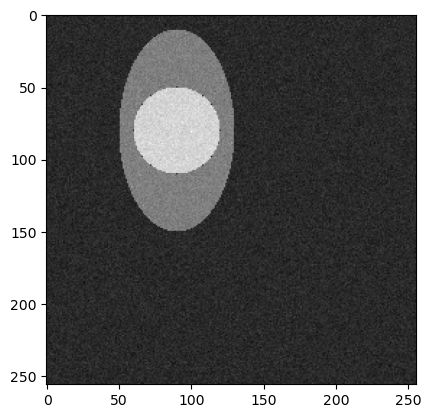

In [ ]:
xx, yy = np.meshgrid(np.arange(256), np.arange(256))
img = np.zeros((256, 256))

rr0 = (xx-90)**2 + (yy-80)**2
img[rr0 < 30**2] = 20.0

# contiguous region
rr1 = (xx-90)**2/40**2 + (yy-80)**2/70**2
img[(rr0 > 30.0**2)*(rr1 < 1.0)] = 10.0

noise = np.random.normal(0,1, img.shape)

img = img + noise

plt.imshow(img, cmap="gray")

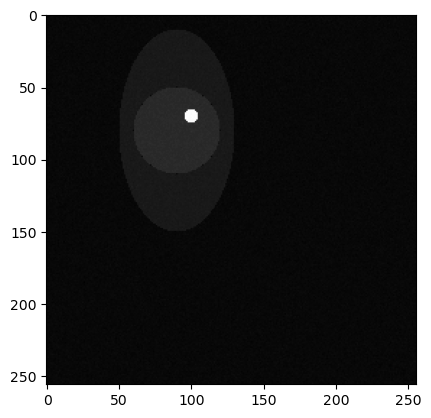

In [30]:
# using a sedd

seed = (100, 70)

x0,  y0 = seed

# draw a circle around the seed
flag = np.zeros(img.shape)
flag[((xx-x0)**2 + (yy-y0)**2) < 5**2] = 125

plt.imshow(img + flag, cmap="gray")



In [12]:
# start a flood filling like process

def distance(x0, y0, x1, y1, image):
    v0 = image[y0, x0]
    v1 = image[y1, x1]
    return abs(v1 - v0)

def N4(x0, y0, M, N):
    # Use a base structure
    heigth = []
    
    if x0 + 1 < M:
        heigth.append((x0 + 1, y0))
    if 0 < x0 - 1:
        heigth.append((x0 - 1, y0))
    if y0 + 1 < N:
        heigth.append((x0, y0 + 1))
    if 0 < y0 - 1:
        heigth.append((x0, y0 - 1))
        
    return heigth


def grow(x0, y0, image, threshold, dist, max_it = 1e6):
    mask = np.zeros(image.shape)
    visited_pixels = np.zeros(image.shape)
    N, M = image.shape
    seed = []
    seed.append((x0, y0))
    it = 0
    while len(seed) > 0:
        x0, y0 = seed.pop()
        for x1, y1 in N4(x0, y0, M, N):
            if distance(x0, y0, x1, y1, image) <= threshold and mask[y1,x1] == 0 and visited_pixels[y1, x1] == 0:
                seed.append((x1, y1))
        mask[y0, x0] = 1
        visited_pixels[y0, x0] = 1
        it = it + 1
        if it > max_it:
            print("overgrowing")
            break
    return mask



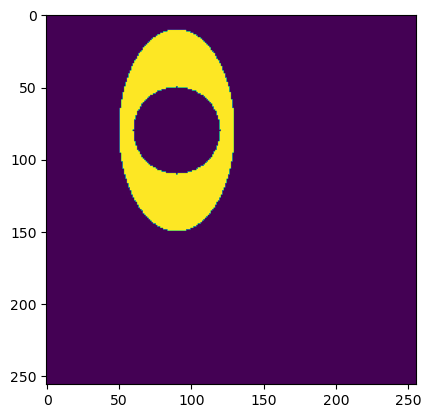

In [28]:
mask = grow(100, 25, img, 4, distance)

plt.imshow(mask)

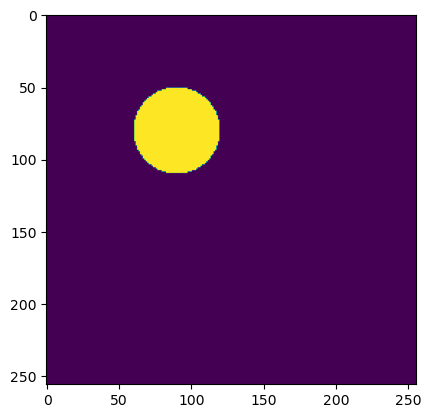

In [33]:
mask = grow(100, 70, img, 4, distance)

plt.imshow(mask)

(597, 514)


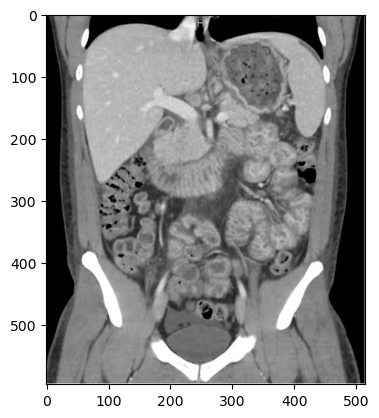

In [37]:
corps_image = cv2.imread("data/corps.JPG")
corps_image = cv2.cvtColor(corps_image, cv2.COLOR_BGR2GRAY)

print(corps_image.shape)

plt.imshow(corps_image, cmap="gray")

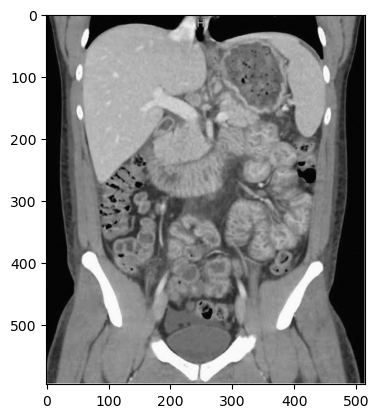

In [39]:
noise = np.random.normal(0,1, corps_image.shape)

corps_image = corps_image + noise

plt.imshow(corps_image, cmap="gray")

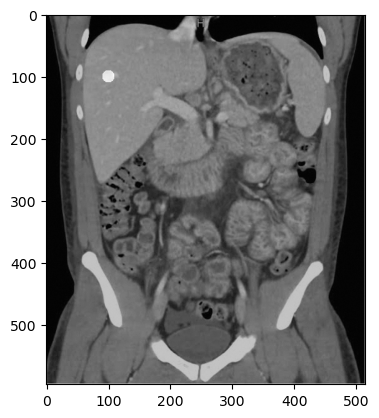

In [51]:
seed2 = (100, 100)
xx, yy = np.meshgrid(np.arange(corps_image.shape[1]), np.arange(corps_image.shape[0]))
x0,  y0 = seed2

# draw a circle around the seed
flag2 = np.zeros(corps_image.shape)
flag2[((xx-x0)**2 + (yy-y0)**2) < 10**2] = 125

plt.imshow(corps_image + flag2, cmap="gray")

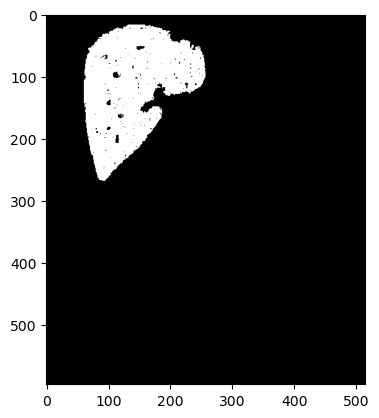

In [ ]:
mask2 = grow(100, 100, corps_image, 5, distance)
plt.imshow(mask2, cmap="gray")

### References

1. paper
2. DRIVE - Grand Challenge. (n.d.). grand-challenge.org. https://drive.grand-challenge.org/